# Image Classification with CIFAR-10 dataset

In this notebook I have extended the work of (https://github.com/deep-diver/CIFAR10-img-classification-tensorflow)

In this notebook, I am going to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. Some more interesting datasets can be found [here](http://rodrigob.github.io/are_we_there_yet/build/#datasets)

Some of the code and description of this notebook is borrowed by [this repo](https://github.com/udacity/deep-learning/tree/master/image-classification) provided by Udacity's Deep Learning Nanodegree program. This notebook has been reproduced decorated with richer descriptions after completing the Udacity's project.

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

#### Some references to look up
- [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html): labeled subsets of the 80 million tiny images dataset. 
- [urlretrieve lib](https://docs.python.org/3.0/library/urllib.request.html): copy a network object denoted by a URL to a local file, if necessary
- [tarfile lib](https://docs.python.org/2/library/tarfile.html): makes it possible to read and write tar archives, including those using gzip or bz2 compression.
- [tqdm lib](https://pypi.python.org/pypi/tqdm): Fast, Extensible Progress Meter

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


## Before Jumping in

### Some references to look up
- [python pickle](https://docs.python.org/3/library/pickle.html): implements binary protocols for serializing and de-serializing a Python object structure.
- [numpy reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html): Gives a new shape to an array without changing its data.
- [numpy transpose](https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html): Permute the dimensions of an array.
- [numpy transpose with list of axes explanation](https://stackoverflow.com/questions/32034237/how-does-numpys-transpose-method-permute-the-axes-of-an-array)
- [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d): check out input with the argument, data_format. "NHWC": [batch, height, width, channels], "NCHW": [batch, channels, height, width].
- [row major order explanation](https://en.wikipedia.org/wiki/Row-_and_column-major_order)

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

### List of files 

![](./list_of_batch_files.png)

As seen above picture, the dataset is broken into batches to **prevent** your machine from running **out of memory**. The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc..


### Understanding the original data 

The original a batch data is (10000 x 3072) dimensional tensor expressed in numpy array, where the number of columns, (10000), indicates the number of sample data. As stated in the [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), the row vector, (3072) represents an color image of 32x32 pixels. Since this project is going to use CNN for the classification tasks, the row vector, (3072), is not an appropriate form of image data to feed. In order to feed an image data into a CNN model, the dimension of the tensor representing an image data should be either (width x height x num_channel) or (num_channel x width x height). It depends on your choice (check out the [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)). In this particular project, I am going to use the dimension of the first choice because the default choice in tensorflow's CNN operation is so.

[O] need to be modified into a new shape

### Understanding the original labels

The label data is just a list of 10000 numbers in the range 0-9, which corresponds to each of the 10 classes in CIFAR-10. 

* **airplane**
* **automobile**
* **bird**
* **cat**
* **deer**
* **dog**
* **frog**
* **horse**
* **ship**
* **truck**

[X] need to be modified into a new shape


In [3]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### How to reshape into a such form?

The row vector (3072) has the exact same number of elements if you calculate 32\*32\*3==3072. In order to reshape the row vector, (3072), there are two steps required. The **first** step is involved with using **reshape** function in numpy, and the **second** step is involved with using **transpose** function in numpy as well.

By definition from the official web site, **reshape** function gives a new shape to an array without changing its data. Here, the phrase **without changing its data** is an important part. **reshape** operations should be delivered in three more detailed step. The following direction is described in a logical concept. 

1. divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
  - this results in (3 x 1024) dimension of tensor
2. divide the resulting tensor from the previous step with 32. 32 here means width of an image.
  - this results in (3 x 32 x 32)

In order to implement the directions written in logical sense in numpy, **reshape** function should be called in the following arguments, (10000, 3, 32, 32). As you noticed, reshape function doesn't automatically divide further when the third value (32, width) is provided. We need to explicitly specify the value for the last value (32, height)


This is not the end of story. Now, the image data is represented as (num_channel, width, height) form. However, **this is not the shape tensorflow and matplotlib are expecting**. They are expecting different shape of (width, height, num_channel) instead. We need to swap the order of each axes, and that is where **transpose** function comes in.

The **transpose** function can take a list of axes, and each value specifies where it wants to move around. For example, calling transpose with argument (1, 2, 0) in an numpy array of (num_channel, width, height) will return a new numpy array of (width, height, num_channel).

<img src="./reshape-transpose.png" alt="Drawing" style="width: 800px;"/>

In [4]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Explore the Data

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

The display_stats defined below answers some of questions like in a given batch of data..
- "What are all possible labels?"
- "What is the range of values for the image data?"
- "Are the labels in order or random?"


In [5]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


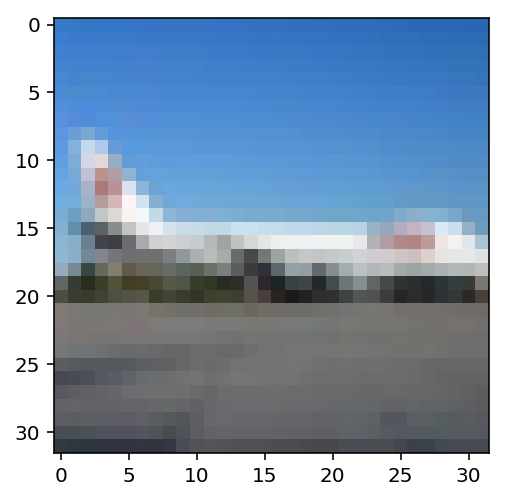

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
**Min-Max Normalization**
- this simply makes all x values to range between 0 and 1.
- y = (x-min) / (max-min)

**Some references to look up**
- [Min-Max Normalization](https://www.quora.com/What-is-the-meaning-of-min-max-normalization)
- [Watch "why normalizing inputs" / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=FDCfw-YqWTE)
- [Exploding, Vainishing Gradient descent / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=qhXZsFVxGKo)

`normalize` function takes an image data, `x`, and returns it as a normalized Numpy array. The values in the original data is going to be transformed in range of 0 to 1, inclusive without change the shape of the array. A simply answer to why normalization should be performed is somewhat related to activation function.

For example, sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarily, when the input value is somewhat small, the output value easily reaches the max value 0. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/480px-Logistic-curve.svg.png" alt="Drawing" style="width: 300px;"/>

For another example, ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. When the input value is somewhat large, the output value increases linearly. However, when the input value is somewhat small, the output value easily reaches the max value 0. 

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_4/Relu.jpeg" alt="Drawing" style="width: 300px;"/>

Now, when we think about the image data, all values originally ranges from 0 to 255. This sounds like when it is passed into sigmoid function, the output is almost always 1, and when it is passed into ReLu function, the output could be very huge. When backpropagation process is performed to optimize the networks, this could lead to an exploding gradient which leads to an aweful learning steps. In order to avoid this issue, ideally, it is better let all the values be around 0 and 1.

In [7]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

### One-hot encode

Since the output of our model is going to show the probabilities of where an image should be categorized as a prediction. There should be a vector having the same number of elements as the number of image classes. For instance, CIFAR-10 provides 10 different classes of image, so we need a vector in size of 10 as well. Each element represents the predicting probability of each classes.

Also, our model should be able to compare the prediction with the ground truth label. It means the shape of the label data should also be transformed into a vector in size of 10 too. Instead, because label is the ground truth, we set the value 1 to the corresponding element.

**`one_hot_encode`** function takes the input, **`x`**, which is a list of labels(ground truth). The total number of element in the list is the total number of samples in a batch. **`one_hot_encode`** function returns a 2 dimensional tensor, where the number of row is the size of the batch, and the number of column is the number of image classes.

#### some references to look up
- [one hot encoding](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science)

In [8]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

## Preprocess all the data and save it

The code cell below uses the previously implemented functions, normalize and one_hot_encode, to preprocess the given dataset.
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation. 

<img src="./train-valid-test split.png" alt="Drawing" style="width: 700px;"/>

In [10]:


def _remove_classes(features, labels, class_to_remove=[0], keep_every_th=10):

    retain_idx=0
    remove_indices=[]
    # collecting indexes to be removed:
    for idx in range(len(labels)):
        lab = labels[idx]
        for to_remove in class_to_remove:
            if (lab == to_remove):
                if(retain_idx==keep_every_th):
                    retain_idx=0
                else:
                    remove_indices.append(idx)
                retain_idx += 1

    # actual removing
    labels = [i for j, i in enumerate(labels) if j not in remove_indices]
    features = [i for j, i in enumerate(features) if j not in remove_indices]
      
    return features, labels



def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename, remove=True,functions_to_call=[]):
    if(remove==True):
        features, labels = _remove_classes(features, labels, class_to_remove=[0], keep_every_th=10)
    
    for f in functions_to_call:
        features, labels=f(features, labels)
    
    features = normalize(features)
    labels = one_hot_encode(labels)
    pickle.dump((features, labels), open(filename, 'wb'))
    print("check end of _preprocess_and_save "+str(len(features))+" imgs with writing "+filename)
    



def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode,imbalanced=False,data_prefix='', functions_to_call=[]):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        batch_file_name='preprocess_batch_' + str(batch_i) + '.p'
        batch_file_name=data_prefix+batch_file_name
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             batch_file_name,imbalanced,functions_to_call)

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p',remove=False)

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p',remove=False)

In [11]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode,imbalanced=False)
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode,imbalanced=True,data_prefix='imbalanced_')


check end of _preprocess_and_save 9000 imgs with writing preprocess_batch_1.p
check end of _preprocess_and_save 9000 imgs with writing preprocess_batch_2.p
check end of _preprocess_and_save 9000 imgs with writing preprocess_batch_3.p
check end of _preprocess_and_save 9000 imgs with writing preprocess_batch_4.p
check end of _preprocess_and_save 9000 imgs with writing preprocess_batch_5.p
check end of _preprocess_and_save 5000 imgs with writing preprocess_validation.p
check end of _preprocess_and_save 10000 imgs with writing preprocess_training.p
check end of _preprocess_and_save 8189 imgs with writing imbalanced_preprocess_batch_1.p
check end of _preprocess_and_save 8201 imgs with writing imbalanced_preprocess_batch_2.p
check end of _preprocess_and_save 8197 imgs with writing imbalanced_preprocess_batch_3.p
check end of _preprocess_and_save 8186 imgs with writing imbalanced_preprocess_batch_4.p
check end of _preprocess_and_save 8165 imgs with writing imbalanced_preprocess_batch_5.p
chec

## Checkpoint


In [12]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Tensorflow Basic

Before diving in building the network and training process, it is good to remind myself how Tensorflow works. 

### Tensorflow Packages
Tensorflow comes with bunch of packages. You can even find modules having similary functionalities. For instance, tf.nn.conv2d and tf.layers.conv2d are both 2-D convolutional operations. Here are the purposes of the categories of each packages.

#### tf.nn: lower level APIs for neural network
  - each APIs under this package has its sole purpose
  - for instance, in order to apply activation function after conv2d, you need two separate API calls
  - you probably have to set lots of settings by yourself manually

#### tf.layers: higher level APIs for neural network
  - each APIs under this package probably has streamlined processes
  - for instance, in order to apply activation function after conv2d, you don't need two spearate API calls. Intead, conv2d API under this package has activation argument
  - each APIs under this package comes with lots of default setting in arguments
  
#### tf.contrib: contrib module containing volatile or experimental code
  - like the documents explain, this package provides experimental codes
  - you could probably find more handy APIs
  - you could look up this package when you don't find functionality under the main packages
  - It is meant to contain features and contributions that eventually should get merged into core TensorFlow, but you can think of them like under construction

I am going to use APIs under each different packages so that I could be familiar with different API usages. Below is the list of references APIs I am going to use for implementing the entire model.

#### some references to look up

- [Stanford CS20 'Tensorflow for Deep Learning Research'](https://web.stanford.edu/class/cs20si/syllabus.html)

### Tensorflow Workflow

According to the official document, **TensorFlow** uses a **dataflow graph** to represent your computation in terms of the dependencies between individual operations. This leads to a low-level programming model in which you **first define the dataflow graph**, **then** create a TensorFlow **session to run parts of the graph** across a set of local and remote devices.

**Dataflow** is a common programming model for **parallel computing**. In a dataflow graph, the nodes represent units of computation, and the edges represent the data consumed or produced by a computation. For example, in a TensorFlow graph, the tf.matmul operation would correspond to a single node with two incoming edges (the matrices to be multiplied) and one outgoing edge (the result of the multiplication).

Most **TensorFlow** programs **start with a dataflow graph construction phase**. In this phase, you invoke TensorFlow API functions that construct new tf.Operation (node) and tf.Tensor (edge) objects and add them to a tf.Graph instance. **TensorFlow provides a default graph** that is an **implicit argument to all API functions in the same context**.

The **tf.Session.run method** is the main mechanism for **running a tf.Operation or evaluating a tf.Tensor**. You can pass one or more tf.Operation or tf.Tensor objects to tf.Session.run, and TensorFlow will execute the operations that are needed to compute the result.

<img src="https://www.tensorflow.org/versions/r1.3/images/tensors_flowing.gif" alt="Drawing" style="width: 300px;"/>

#### some references to look up
- [Tensorflow Architecture](https://www.tensorflow.org/extend/architecture)
- [Tensorflow Graphs and Sessions](https://www.tensorflow.org/versions/r1.3/programmers_guide/graphs)

## Build the network

The image below depicts what the model would look like in this notebook.

<img src="./conv_model.png" alt="Drawing" style="width: 1000px;"/>

### Prepare Input for the Model

#### some references to look up
- [Tensorflow Data Type](https://www.tensorflow.org/api_docs/python/tf/DType)
- [Tensorflow Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
- [Tensorflow Variable](https://www.tensorflow.org/api_docs/python/tf/Variable)

In [11]:
# Remove previous weights, bias, inputs, etc..
import tensorflow as tf
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Create Convolutional Model

The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

1. Convolution with 64 different filters in size of (3x3)
2. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
3. Convolution with 128 different filters in size of (3x3)
4. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
5. Convolution with 256 different filters in size of (3x3)
6. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
7. Convolution with 512 different filters in size of (3x3)
8. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
9. Flattening the 3-D output of the last convolutional operations.
10. Fully Connected Layer with 128 units
  - Dropout 
  - Batch Normalization
11. Fully Connected Layer with 256 units
  - Dropout 
  - Batch Normalization
12. Fully Connected Layer with 512 units
  - Dropout 
  - Batch Normalization
13. Fully Connected Layer with 1024 units
  - Dropout 
  - Batch Normalization
14. Fully Connected Layer with 10 units (number of image classes)

the image below decribes how the conceptual convolving operation differs from the tensorflow implementation when you use [Channel x Width x Height] tensor format. 

<img src="./convolving.png" alt="Drawing" style="width: 1000px;"/>

#### some references to look up
- [Tensorflow Conv2D under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)
- [Tensorflow ReLU under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/relu)
- [Tensorflow Max Pooling under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)
- [Tensorflow Dropout under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)
- [Tensorflow Batch Normalization under tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization)
- [Tensorflow Flatten under tf.contrib](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)
- [Tensorflow Fully Connected under tf.contrib](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)
- [Batch Normalization (the original paper)](https://arxiv.org/abs/1502.03167)
- [Why does Batch Norm works? / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=NbGUU6ZYtus)
- [Dropout (the original paper)](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
- [Understanding Dropout / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=ARq74QuavAo)
- [Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)
- [What is the meaning of flattening step in a convolutional neural network?](https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network)
- [Convolutional Neural Networks (CNNs / ConvNets) - CS231n](http://cs231n.github.io/convolutional-networks/)
- [Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)
- [Evaluation of the CNN design choices performance on ImageNet-2012](https://github.com/ducha-aiki/caffenet-benchmark)

In [13]:
import tensorflow as tf

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

### Hyperparameters

* `epochs`: number of iterations until the network stops learning or start overfitting
* `batch_size`: highest number that your machine has memory for.  Most people set them to common sizes of memory:
* `keep_probability`: probability of keeping a node using dropout
* `learning_rate`: number how fast the model learns

In [13]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

### Cost Function & Optimizer

- [Tensorflow Softmax Cross Entropy with Logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2)
- [Tensorflow Reduce Mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)
- [Tensorflow Optimizers](https://www.tensorflow.org/api_guides/python/train)
- [Tensorflow Equal](https://www.tensorflow.org/api_docs/python/tf/equal)
- [Tensorflow Cast](https://www.tensorflow.org/api_docs/python/tf/cast)
- [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)
- [Optimization for Training Deep Models](http://www.deeplearningbook.org/contents/optimization.html)

In [15]:
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Train the Neural Network

We have defined cost, optimizer and accuracy, and what they really are is..
- **cost**:  
   - tf.reduce_mean returns => The reduced **Tensor**
- **optimizer**:  
   - tf.train.AdamOptimizer returns => An **Operation** that applies the specified gradients.
- **accuracy**: 
   - tf.reduce_mean returns => The reduced **Tensor**

tf.Session.run method in the official document explains it runs one "step" of TensorFlow computation, by running the necessary graph fragment to execute every Operation and evaluate every Tensor in fetches, substituting the values in feed_dict for the corresponding input values. The fetches argument may be a single graph element, or an arbitrarily nested list, tuple, etc.

Here what graph element really is tf.Tensor or tf.Operation. Cost, Optimizer, and Accuracy are one of those types meaning they can be specified as part of the fetches argument. Then, we can feed some variables along the way. This is kind of handy feature of Tensorflow. Once we have constructed the graph, all we need to do is feeding data into that graph and specifying what results to retrieve.



#### some references to look up
- [Tensorflow Session run function](https://www.tensorflow.org/api_docs/python/tf/Session#run)
- [Tensorflow tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)
- [Tensorflow tf.train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

### Single Optimization


In [14]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

### Show Stats


In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Fully Train the Model

In [16]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size,data_prefix=''):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    filename= data_prefix+filename
    
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [19]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1773 Validation Accuracy: 0.194200
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8808 Validation Accuracy: 0.265000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.4989 Validation Accuracy: 0.345800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6494 Validation Accuracy: 0.366800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.3035 Validation Accuracy: 0.443800
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3154 Validation Accuracy: 0.518600
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.1142 Validation Accuracy: 0.541400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.0291 Validation Accuracy: 0.557200
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.8715 Validation Accuracy: 0.626200
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.6386 Validation Accuracy: 0.639000
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.7637 Validation Accuracy: 0.653200
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.5781 Validation Accuracy: 0.662400
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.3889 Validation Accuracy: 0.665800


In [17]:
#defining converting images for later usage.

import skimage.transform

def convert_images(features):
    totalImages= None
    newImages = None
    buffer_size= 100
    i=0
    for image in features:
        newImage = skimage.transform.resize(image, (224, 224), mode='constant')
        #TODO this is slow, change to fixed sized arrays and/or use file cache
        if(newImages is None):
            newImages=np.array([newImage])
        else:
            newImages=np.append(newImages,[newImage],axis=0)
        i+=1
        if i==buffer_size:
            print(str(buffer_size)+"imgs, ",end='')
            i=0
            if(totalImages is None):
                totalImages=newImages
            else:
                totalImages=np.append(totalImages,newImages,axis=0)
            newImages=None
    if(totalImages is None):
        #this is when the original features is smaller than buffer size.
        totalImages=newImages
    
    return totalImages



# Checkpoint
The model has been saved to disk.
## Test Model

In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 20))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]

            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name+', predicted: '+pred_names[0])
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random
from sklearn.metrics import classification_report
import os.path
import sys

def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])


def try_to_load_as_pickled_object_or_None(filepath):
    """
    This is a defensive way to write pickle.load, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj



save_model_path = './image_classification'
batch_size = 64
n_samples = 20
top_n_predictions = 10

def test_model(model_path,display=True,title='',convertImgTo224=False):
    tf.reset_default_graph()
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    if(convertImgTo224):
        cache_file_name='preprocess_training_224_3000.p'
        if os.path.isfile(cache_file_name) is False:
            print("converting pictures to 224x224")
            test_features=test_features[0:3000]
            test_features=convert_images(test_features)
            save_as_pickled_object(test_features, cache_file_name)
        else:
            print("loading converted pictures of 224x224")
            test_features=try_to_load_as_pickled_object_or_None(cache_file_name)
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        print("Loading model: "+model_path)
        loader = tf.train.import_meta_graph(model_path + '.meta')
        loader.restore(sess, model_path)

        # Get Tensors from loaded model
        loaded_keep_prob = None
        if(convertImgTo224 is False):
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        else:
            loaded_keep_prob = tf.Variable(1.0)
            
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        
        
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        if display==True:
            random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
            random_test_predictions = sess.run(
                tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
                feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
            display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)

        test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits)),
            feed_dict={loaded_x:test_features, loaded_y: test_labels, loaded_keep_prob: 1.0})

        print("Classification Report: "+str(title))
        print()
        test_prediction_correct_shape=np.reshape(test_predictions.indices,len(test_predictions.indices)).tolist()
        test_labels_correct_shape= np.argmax(test_labels, axis=1).tolist()
        test_labels_correct_shape= test_labels_correct_shape[0:len(test_prediction_correct_shape)]
        print(classification_report(test_labels_correct_shape, test_prediction_correct_shape, target_names=load_label_names()))

        


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7158638535031847

Classification Report: Baseline CNN on original CIFAR-10

              precision    recall  f1-score   support

    airplane       0.89      0.63      0.74      1000
  automobile       0.92      0.79      0.85      1000
        bird       0.64      0.58      0.61      1000
         cat       0.46      0.58      0.52      1000
        deer       0.71      0.65      0.68      1000
         dog       0.52      0.75      0.61      1000
        frog       0.76      0.84      0.80      1000
       horse       0.84      0.71      0.77      1000
        ship       0.86      0.83      0.84      1000
       truck       0.82      0.81      0.82      1000

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000



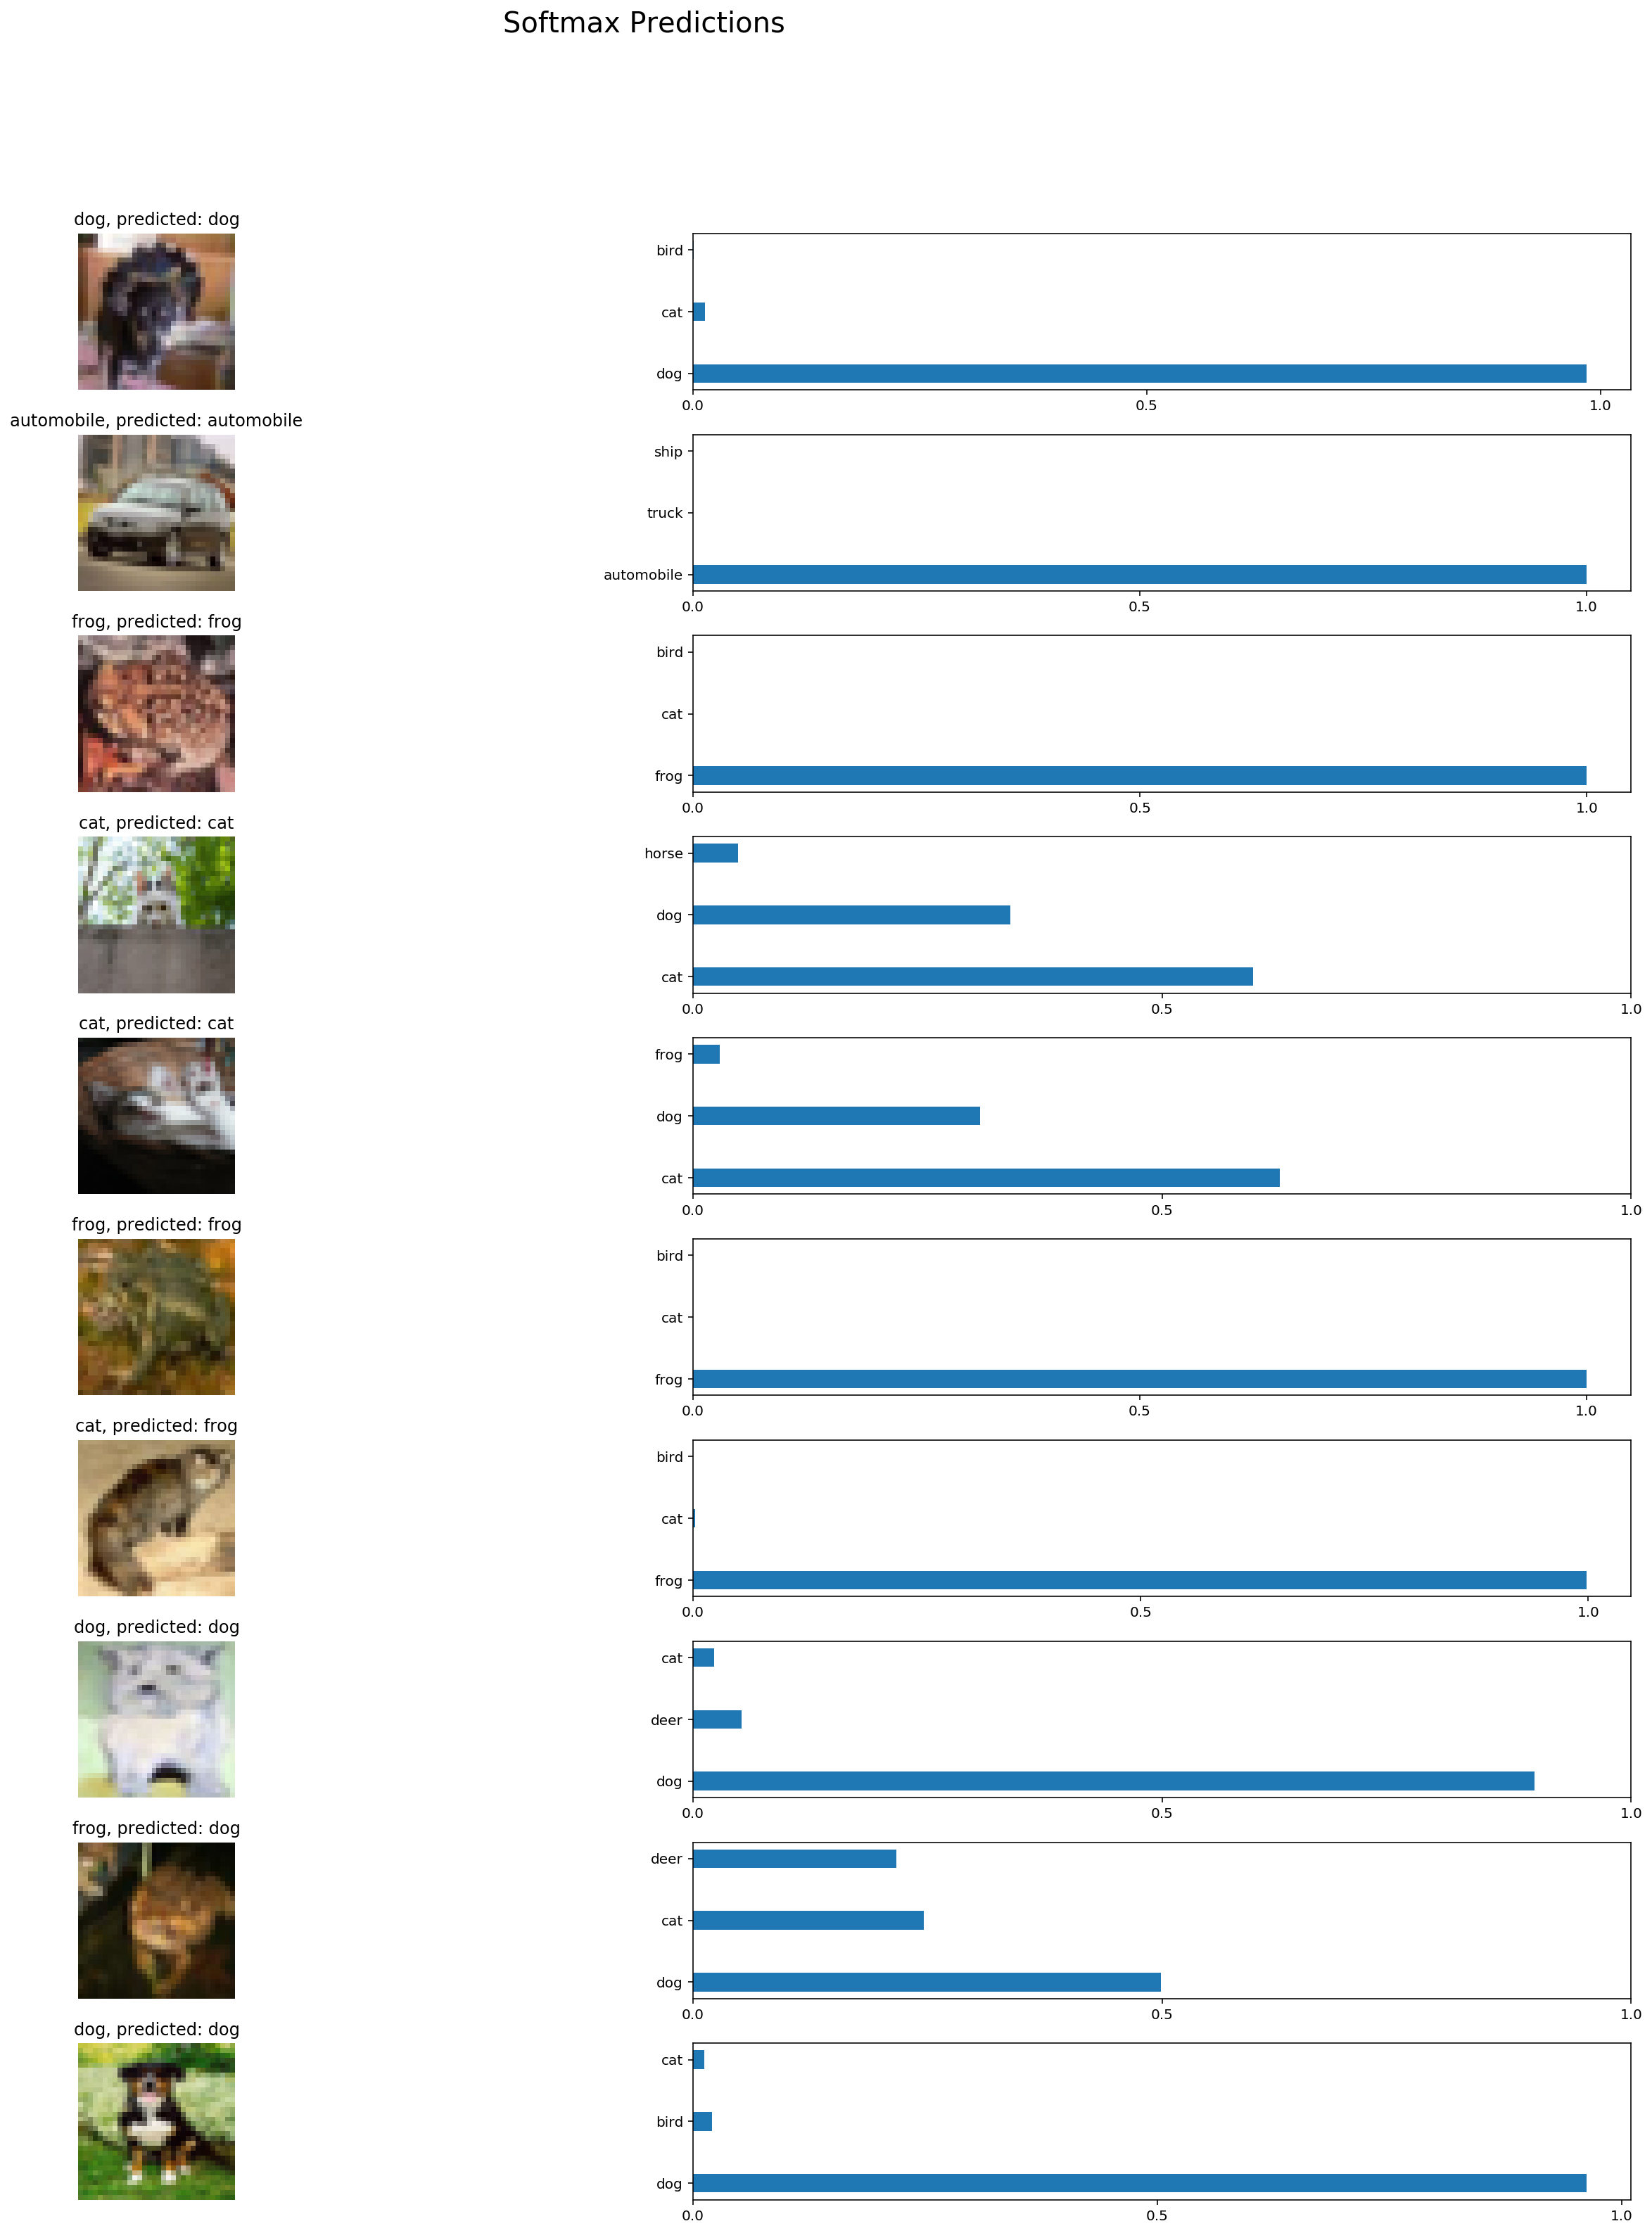

In [22]:

save_model_path = './image_classification'
test_model(save_model_path,display=True,title='Baseline CNN on original CIFAR-10')

## Other Models & their Accuracies 
[Classification datasets results - well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)

In [23]:

save_model_path = './image_classification_imbalanced'

print('Training Imbalanced...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size,data_prefix='imbalanced_'):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training Imbalanced...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.9277 Validation Accuracy: 0.270200
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.4329 Validation Accuracy: 0.373200
Epoch  1, CIFAR-10 Batch 3:  Loss:     0.9463 Validation Accuracy: 0.417400
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.3169 Validation Accuracy: 0.484200
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.1194 Validation Accuracy: 0.479600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.2367 Validation Accuracy: 0.536000
Epoch  2, CIFAR-10 Batch 2:  Loss:     0.8055 Validation Accuracy: 0.543200
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.4986 Validation Accuracy: 0.569600
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.0291 Validation Accuracy: 0.595000
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.6378 Validation Accuracy: 0.599800
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.0028 Validation Accuracy: 0.607600
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.3316 Validation Accuracy: 0.595400
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.2357 Validation Accuracy

INFO:tensorflow:Restoring parameters from ./image_classification_imbalanced
Testing Accuracy: 0.658140923566879

Classification Report: CNN on imbalanced CIFAR-10 (removed 90% airplanes)

              precision    recall  f1-score   support

    airplane       0.94      0.16      0.28      1000
  automobile       0.88      0.83      0.86      1000
        bird       0.64      0.51      0.56      1000
         cat       0.39      0.58      0.47      1000
        deer       0.71      0.60      0.65      1000
         dog       0.46      0.77      0.58      1000
        frog       0.84      0.73      0.78      1000
       horse       0.82      0.70      0.75      1000
        ship       0.65      0.90      0.75      1000
       truck       0.81      0.80      0.80      1000

   micro avg       0.66      0.66      0.66     10000
   macro avg       0.71      0.66      0.65     10000
weighted avg       0.71      0.66      0.65     10000



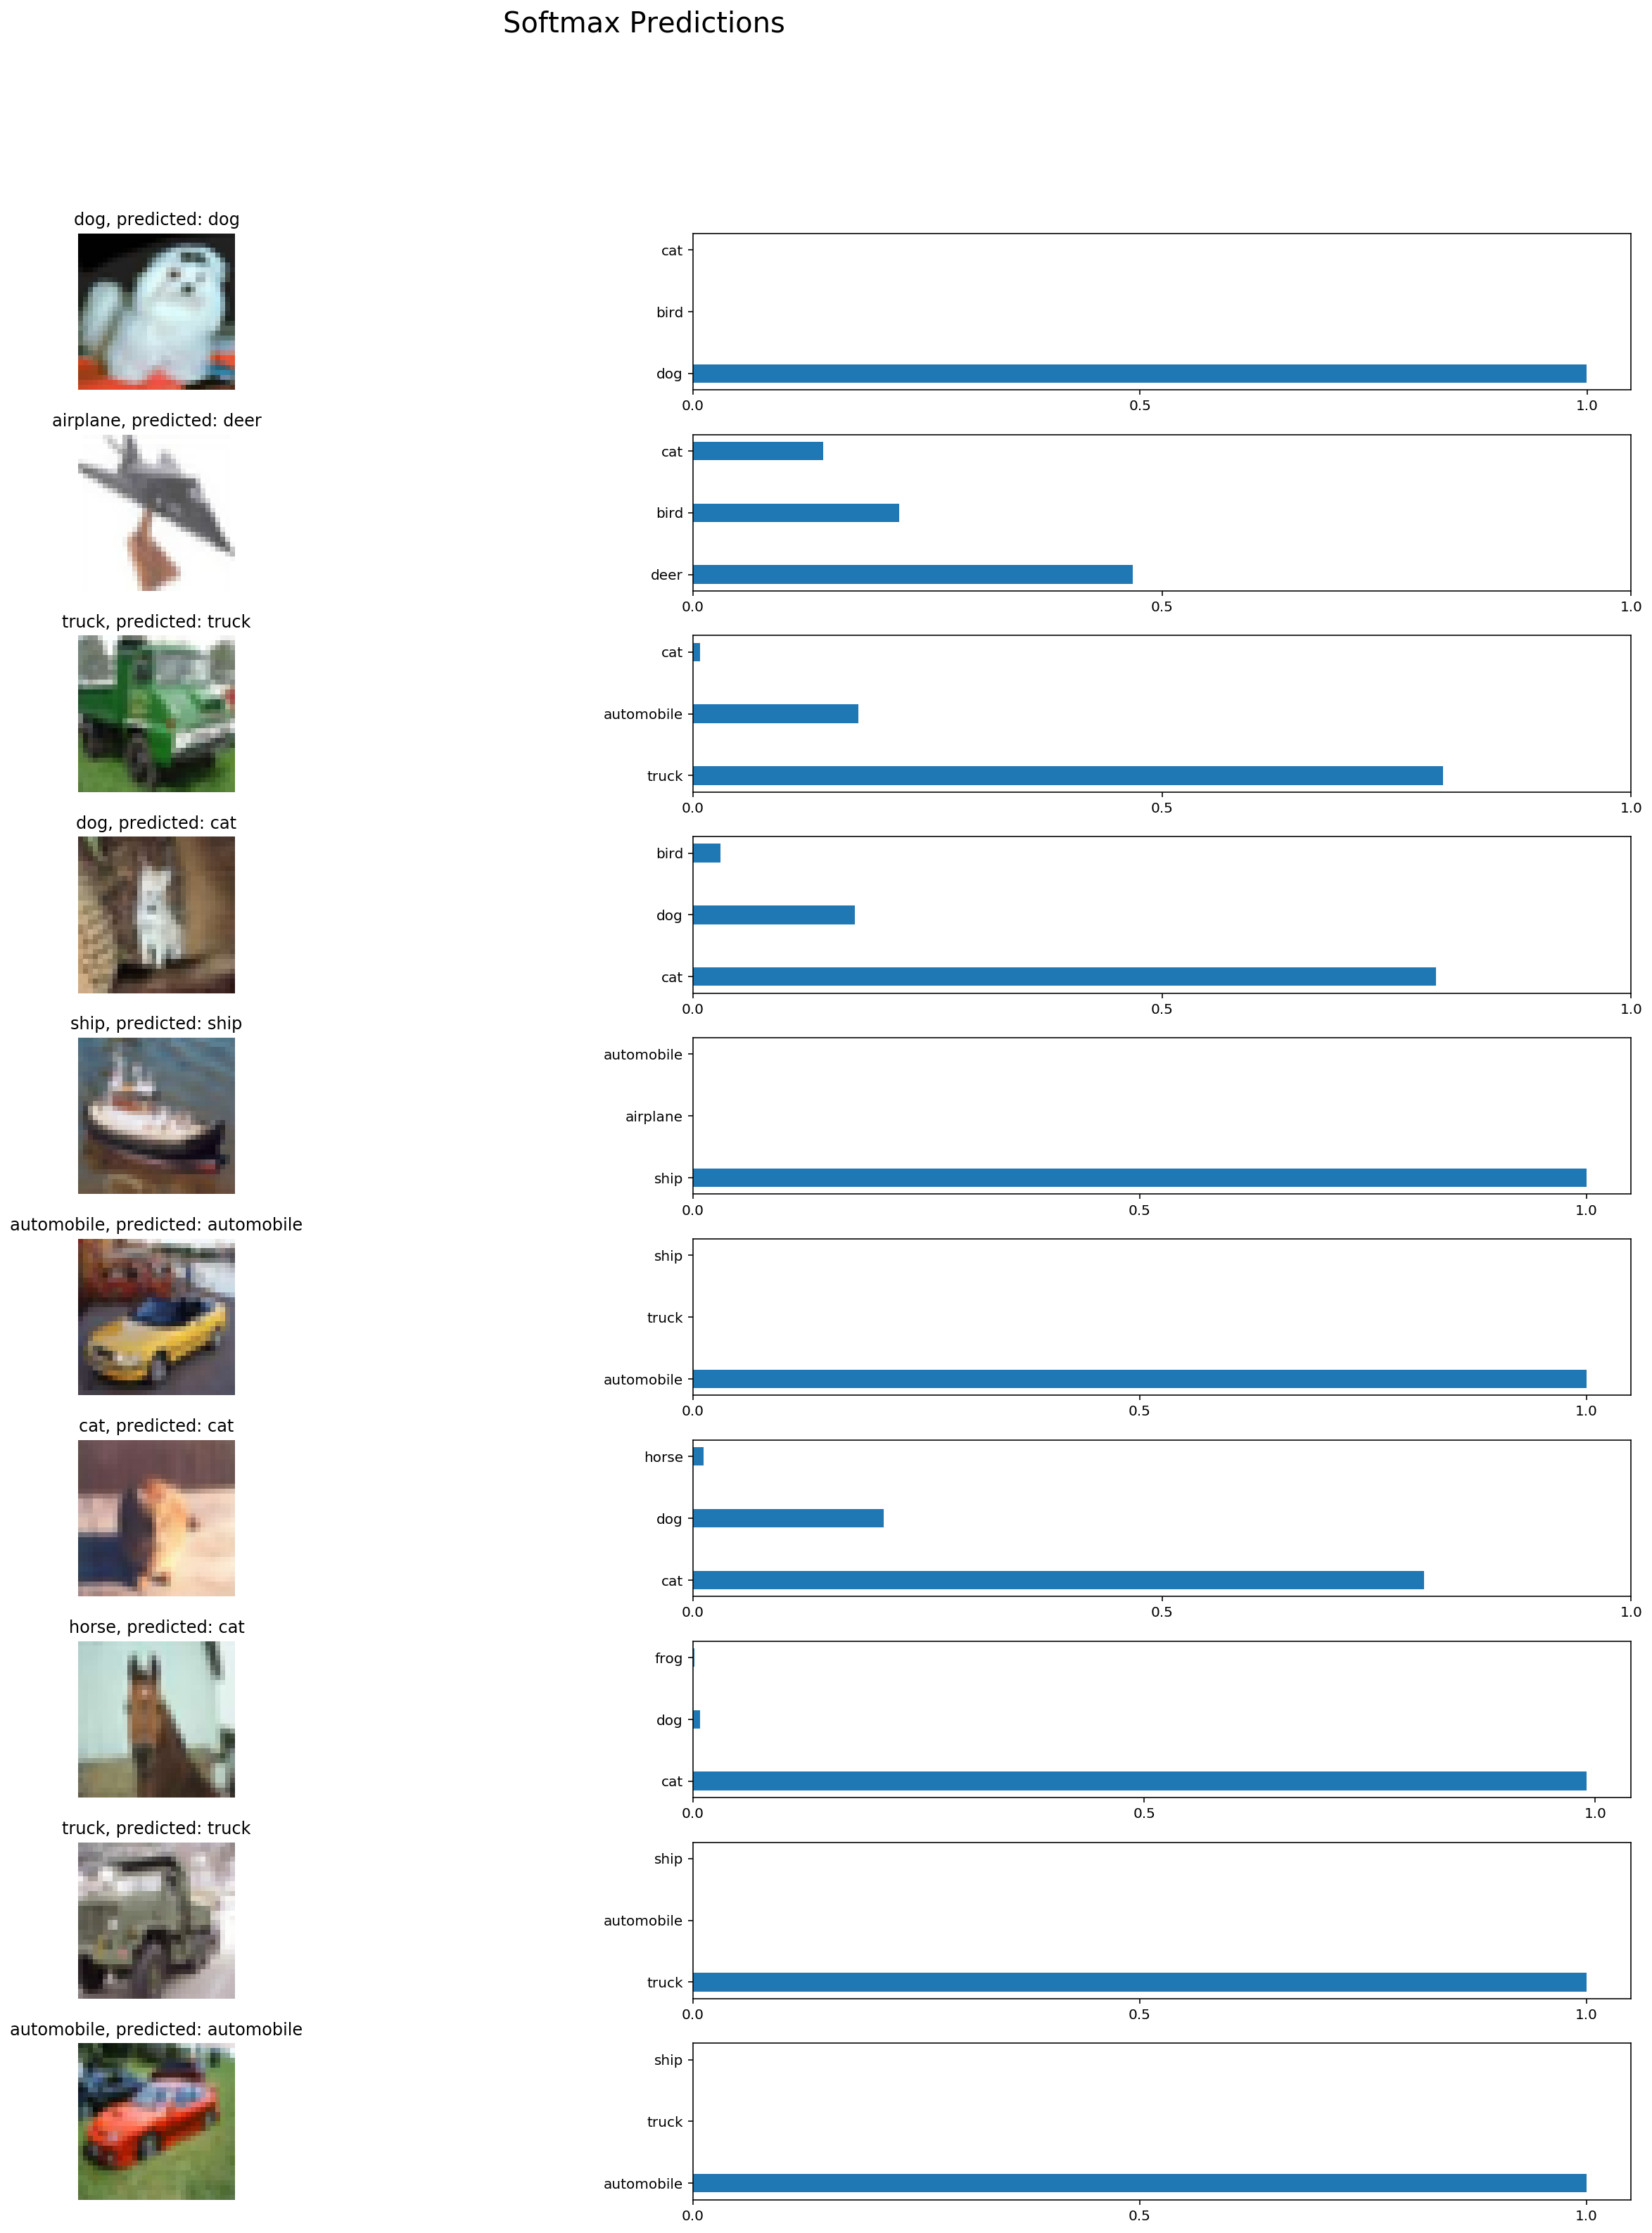

In [24]:
save_model_path = './image_classification_imbalanced'
test_model(save_model_path,title='CNN on imbalanced CIFAR-10 (removed 90% airplanes)')


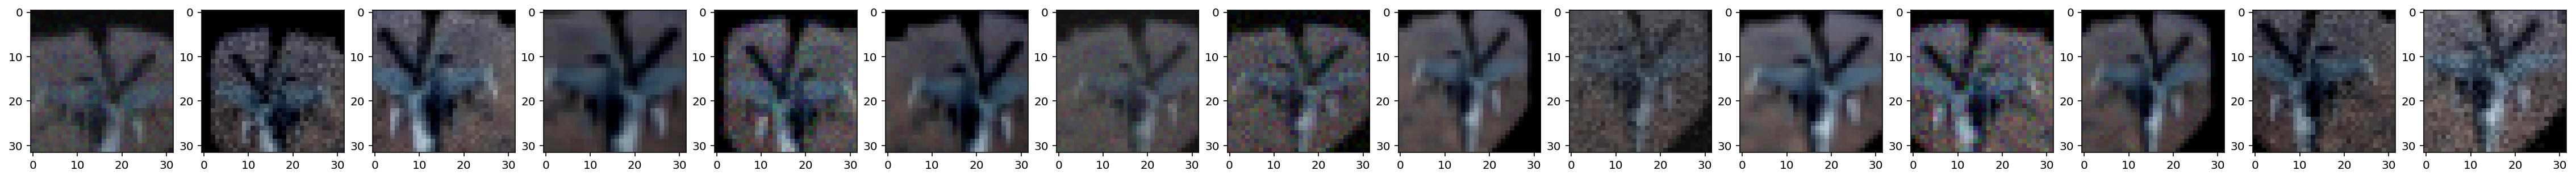

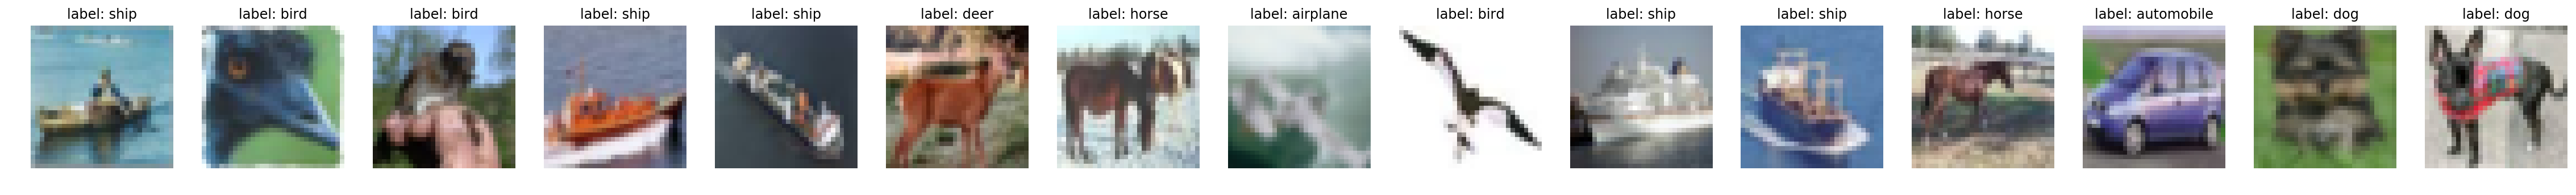

check end of _preprocess_and_save 11069 imgs with writing imbalanced_augmented_preprocess_batch_1.p


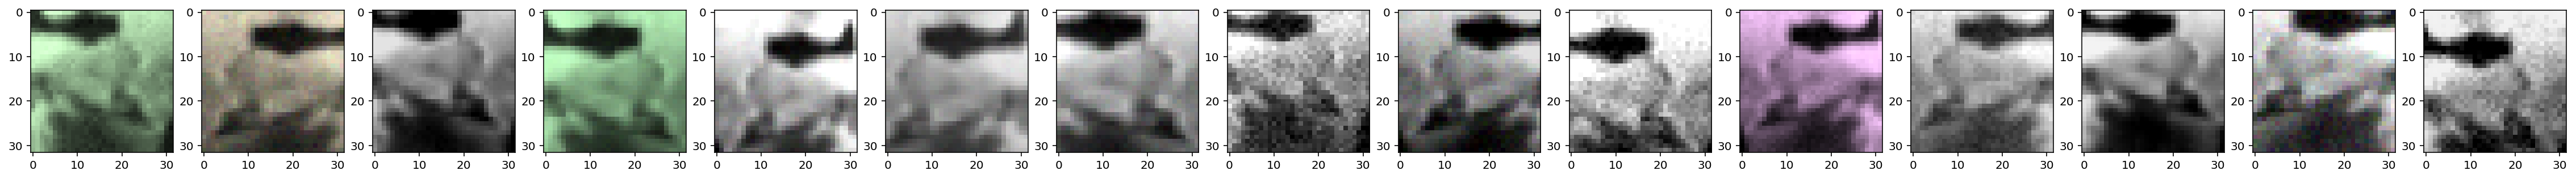

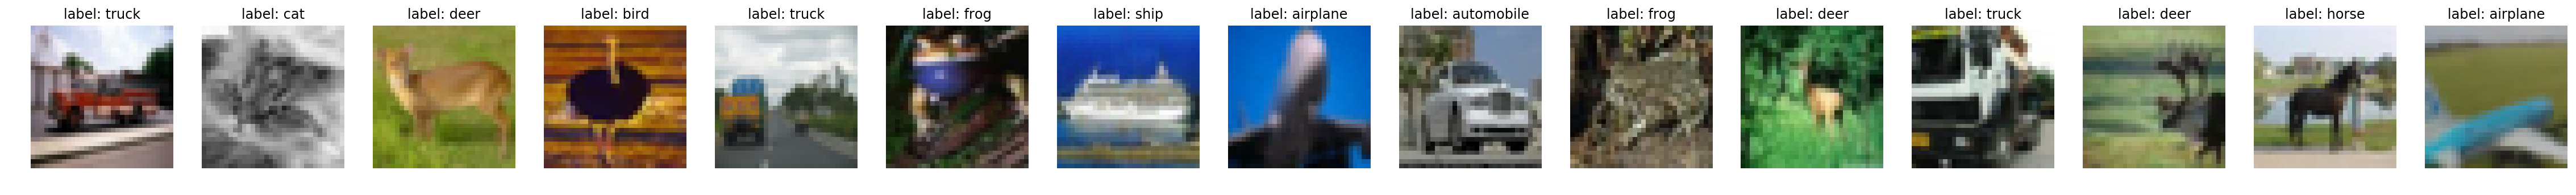

check end of _preprocess_and_save 11017 imgs with writing imbalanced_augmented_preprocess_batch_2.p


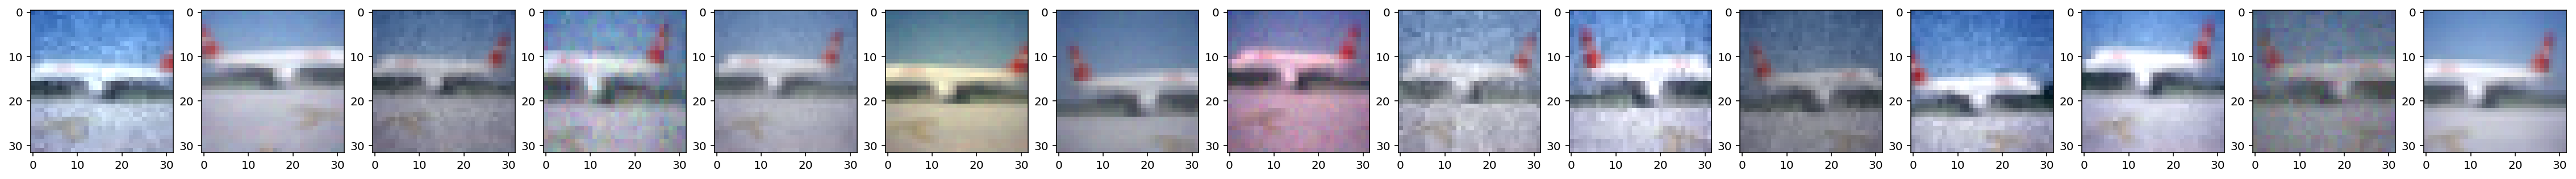

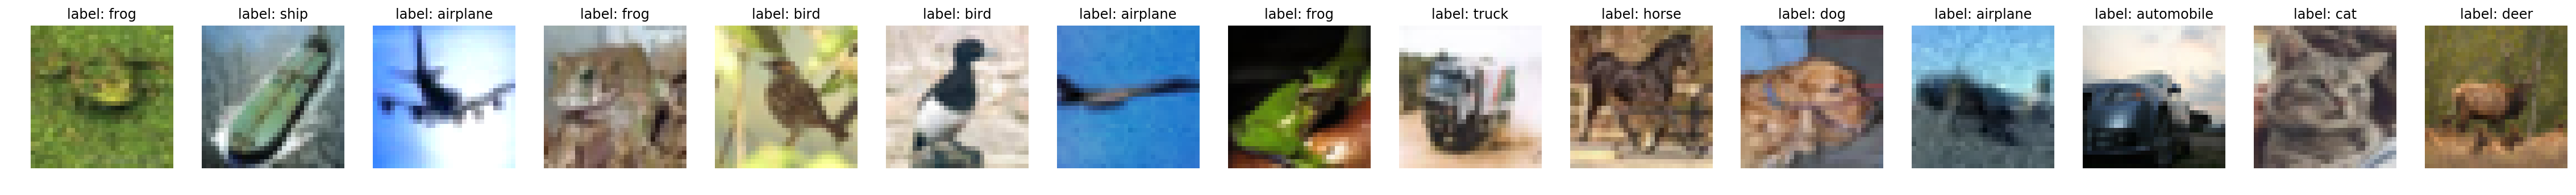

check end of _preprocess_and_save 11045 imgs with writing imbalanced_augmented_preprocess_batch_3.p


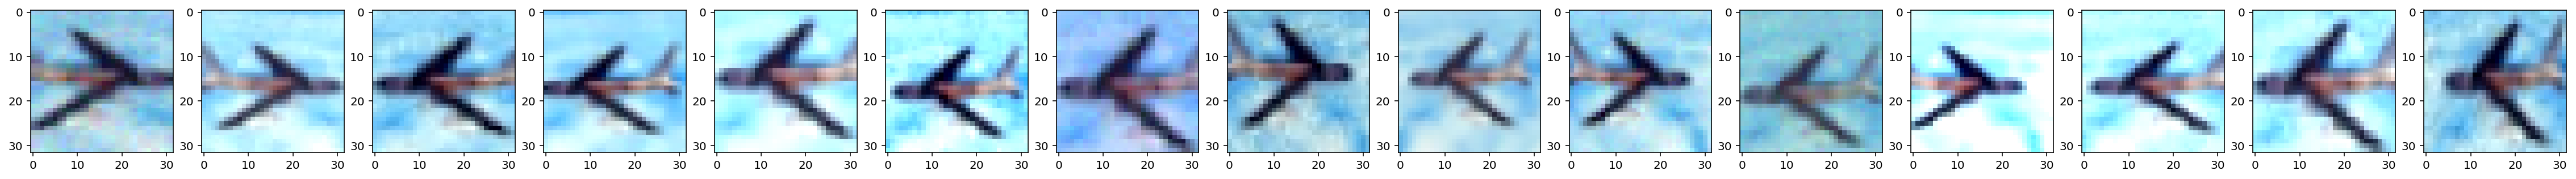

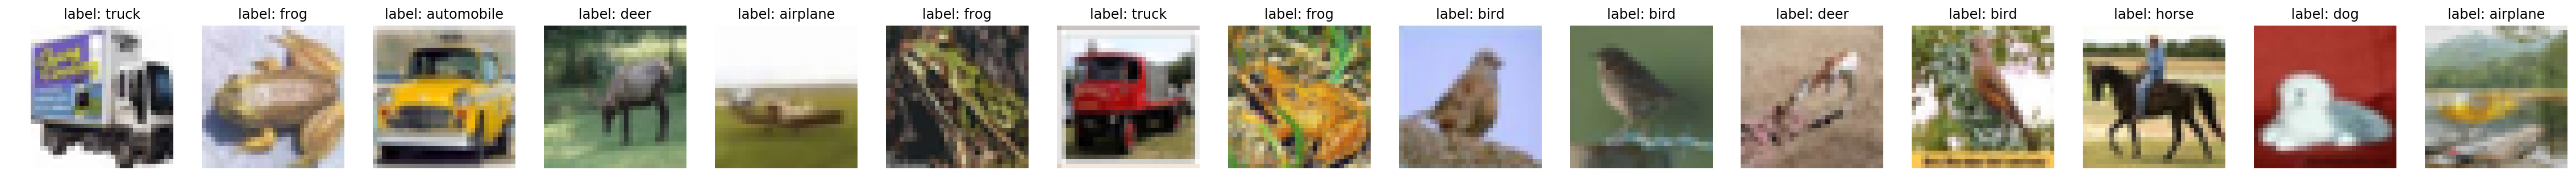

check end of _preprocess_and_save 11066 imgs with writing imbalanced_augmented_preprocess_batch_4.p


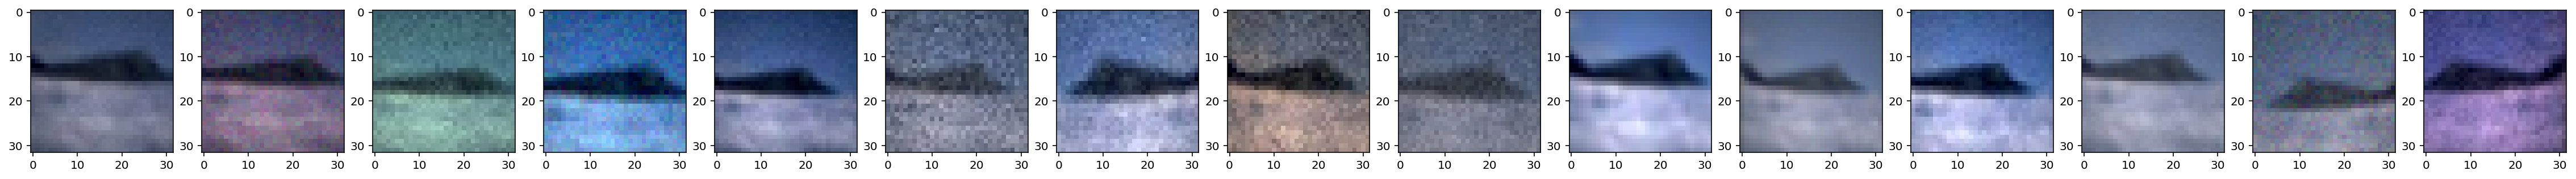

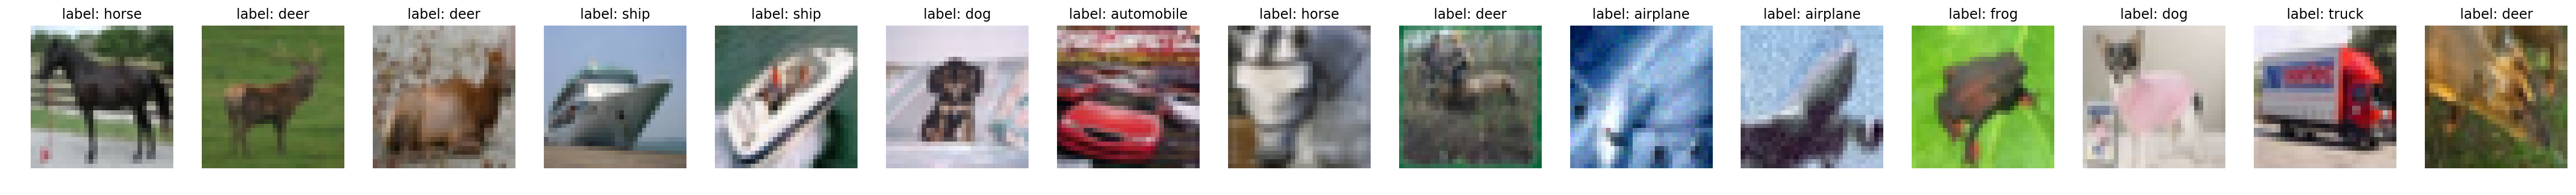

check end of _preprocess_and_save 11109 imgs with writing imbalanced_augmented_preprocess_batch_5.p
check end of _preprocess_and_save 5000 imgs with writing preprocess_validation.p
check end of _preprocess_and_save 10000 imgs with writing preprocess_training.p


In [20]:
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
ia.seed(1)
%matplotlib inline 


# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
#images = np.array(
#    [ia.quokka(size=(64, 64)) for _ in range(32)],
#    dtype=np.uint8
#)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.2)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.2,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    #iaa.Affine(
    #    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
    #    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    #    rotate=(-10, 10),
    #    shear=(-8, 8)
    #)
], random_order=True) # apply augmenters in random order

#images_aug = seq.augment_images(images)

def _augment_images(features, labels):
    #TODO configurable classes:
    class_to_augment=[0]
    
    np_features=np.array(features)
    np_labels=np.array(labels)
    
    retain_idx=0
    augment_indices=[]
    # collecting indexes to be augmented:
    for idx in range(len(labels)):
        lab = labels[idx]
        for to_augment in class_to_augment:
            if (lab == to_augment):
                augment_indices.append(idx)
    
    #selected classes, e.g. aeroplanes
    selected_class_imgs=np_features[augment_indices]
    selected_class_labels=np_labels[augment_indices]
    
    # multiplication of images:
    multiply_factor=32
    selected_class_imgs = np.array(
        [selected_class_imgs for _ in range(multiply_factor)],
        dtype=np.uint8
    )
    selected_class_labels = np.array(
        [selected_class_labels for _ in range(multiply_factor)]
    )
    
    nr_original_images_in_batch=selected_class_imgs.shape[1]
    nr_original_labels_in_batch=selected_class_labels.shape[1]
    selected_class_imgs=np.reshape(selected_class_imgs, (nr_original_images_in_batch*multiply_factor,32,32,3))
    selected_class_labels=np.reshape(selected_class_labels,(nr_original_labels_in_batch*multiply_factor))
    
    #Actual Augmentation
    selected_class_imgs=seq.augment_images(selected_class_imgs)
    #Plotting sample images:
    plot_nr_images=15
    f, axarr = plt.subplots(1,plot_nr_images,figsize=(40,10))
    for i in range(plot_nr_images):
        axarr[i].imshow(selected_class_imgs[i*nr_original_images_in_batch])
    plt.show()
    

    # Concatenate to list
    appended_features=np.append(np_features,selected_class_imgs,axis=0)
    # shuffle idx
    suffle_idx=np.random.rand(appended_features.shape[0]).argsort()
    # doing shuffle with idx
    np.take(appended_features,suffle_idx,axis=0,out=appended_features)
    features=appended_features.tolist()
    
    appended_lables=np.append(np_labels,selected_class_labels,axis=0)
    # doing shuffle with idx
    np.take(appended_lables,suffle_idx,axis=0,out=appended_lables)
    labels=appended_lables.tolist()
    
    #statistics:
    #print("new features and labels shape")
    #print("features appended: "+str(appended_features.shape))
    #print("labels appended: "+str(appended_lables.shape))
    
    np_features=np.array(features)
    np_labels=np.array(labels)
    
    plot_nr_images=15
    f, axarr = plt.subplots(1,plot_nr_images,figsize=(40,10))
    label_names=load_label_names()
    for i in range(plot_nr_images):
        
        axarr[i].imshow(np_features[i])
        axarr[i].set_title('label: '+label_names[np_labels[i]])
        axarr[i].set_axis_off()
    plt.show()
    
    return features, labels 

#function reference:
augment_imgs=_augment_images

preprocess_and_save_data(cifar10_dataset_folder_path, normalize, \
                         one_hot_encode,imbalanced=True,\
                         data_prefix='imbalanced_augmented_',functions_to_call=[augment_imgs])



In [27]:
save_model_path = './image_classification_imbalanced_augmented'

epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

print('Training Imbalanced Augmented...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            nr_train_data=0
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size,data_prefix='imbalanced_augmented_'):
                nr_train_data+=batch_features.shape[0]
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print("number of training samples: "+str(nr_train_data))
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    


Training Imbalanced Augmented...
number of training samples: 11069
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.8164 Validation Accuracy: 0.162600
number of training samples: 11017
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.7410 Validation Accuracy: 0.128000
number of training samples: 11045
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.5951 Validation Accuracy: 0.242000
number of training samples: 11066
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.2115 Validation Accuracy: 0.342400
number of training samples: 11109
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.3477 Validation Accuracy: 0.381600
number of training samples: 11069
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.1058 Validation Accuracy: 0.426800
number of training samples: 11017
Epoch  2, CIFAR-10 Batch 2:  Loss:     0.9490 Validation Accuracy: 0.463800
number of training samples: 11045
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.9854 Validation Accuracy: 0.503600
number of training samples: 11066
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.7871 Validat

INFO:tensorflow:Restoring parameters from ./image_classification_imbalanced_augmented
Testing Accuracy: 0.6964570063694268

Classification Report: CNN on imbalanced CIFAR-10 (removed 90% airplanes) and kept airplains augmented 32 times

              precision    recall  f1-score   support

    airplane       0.86      0.38      0.53      1000
  automobile       0.81      0.89      0.85      1000
        bird       0.58      0.62      0.60      1000
         cat       0.47      0.61      0.53      1000
        deer       0.74      0.61      0.67      1000
         dog       0.59      0.65      0.62      1000
        frog       0.84      0.75      0.79      1000
       horse       0.71      0.81      0.76      1000
        ship       0.84      0.83      0.84      1000
       truck       0.73      0.83      0.78      1000

   micro avg       0.70      0.70      0.70     10000
   macro avg       0.72      0.70      0.69     10000
weighted avg       0.72      0.70      0.69     10000



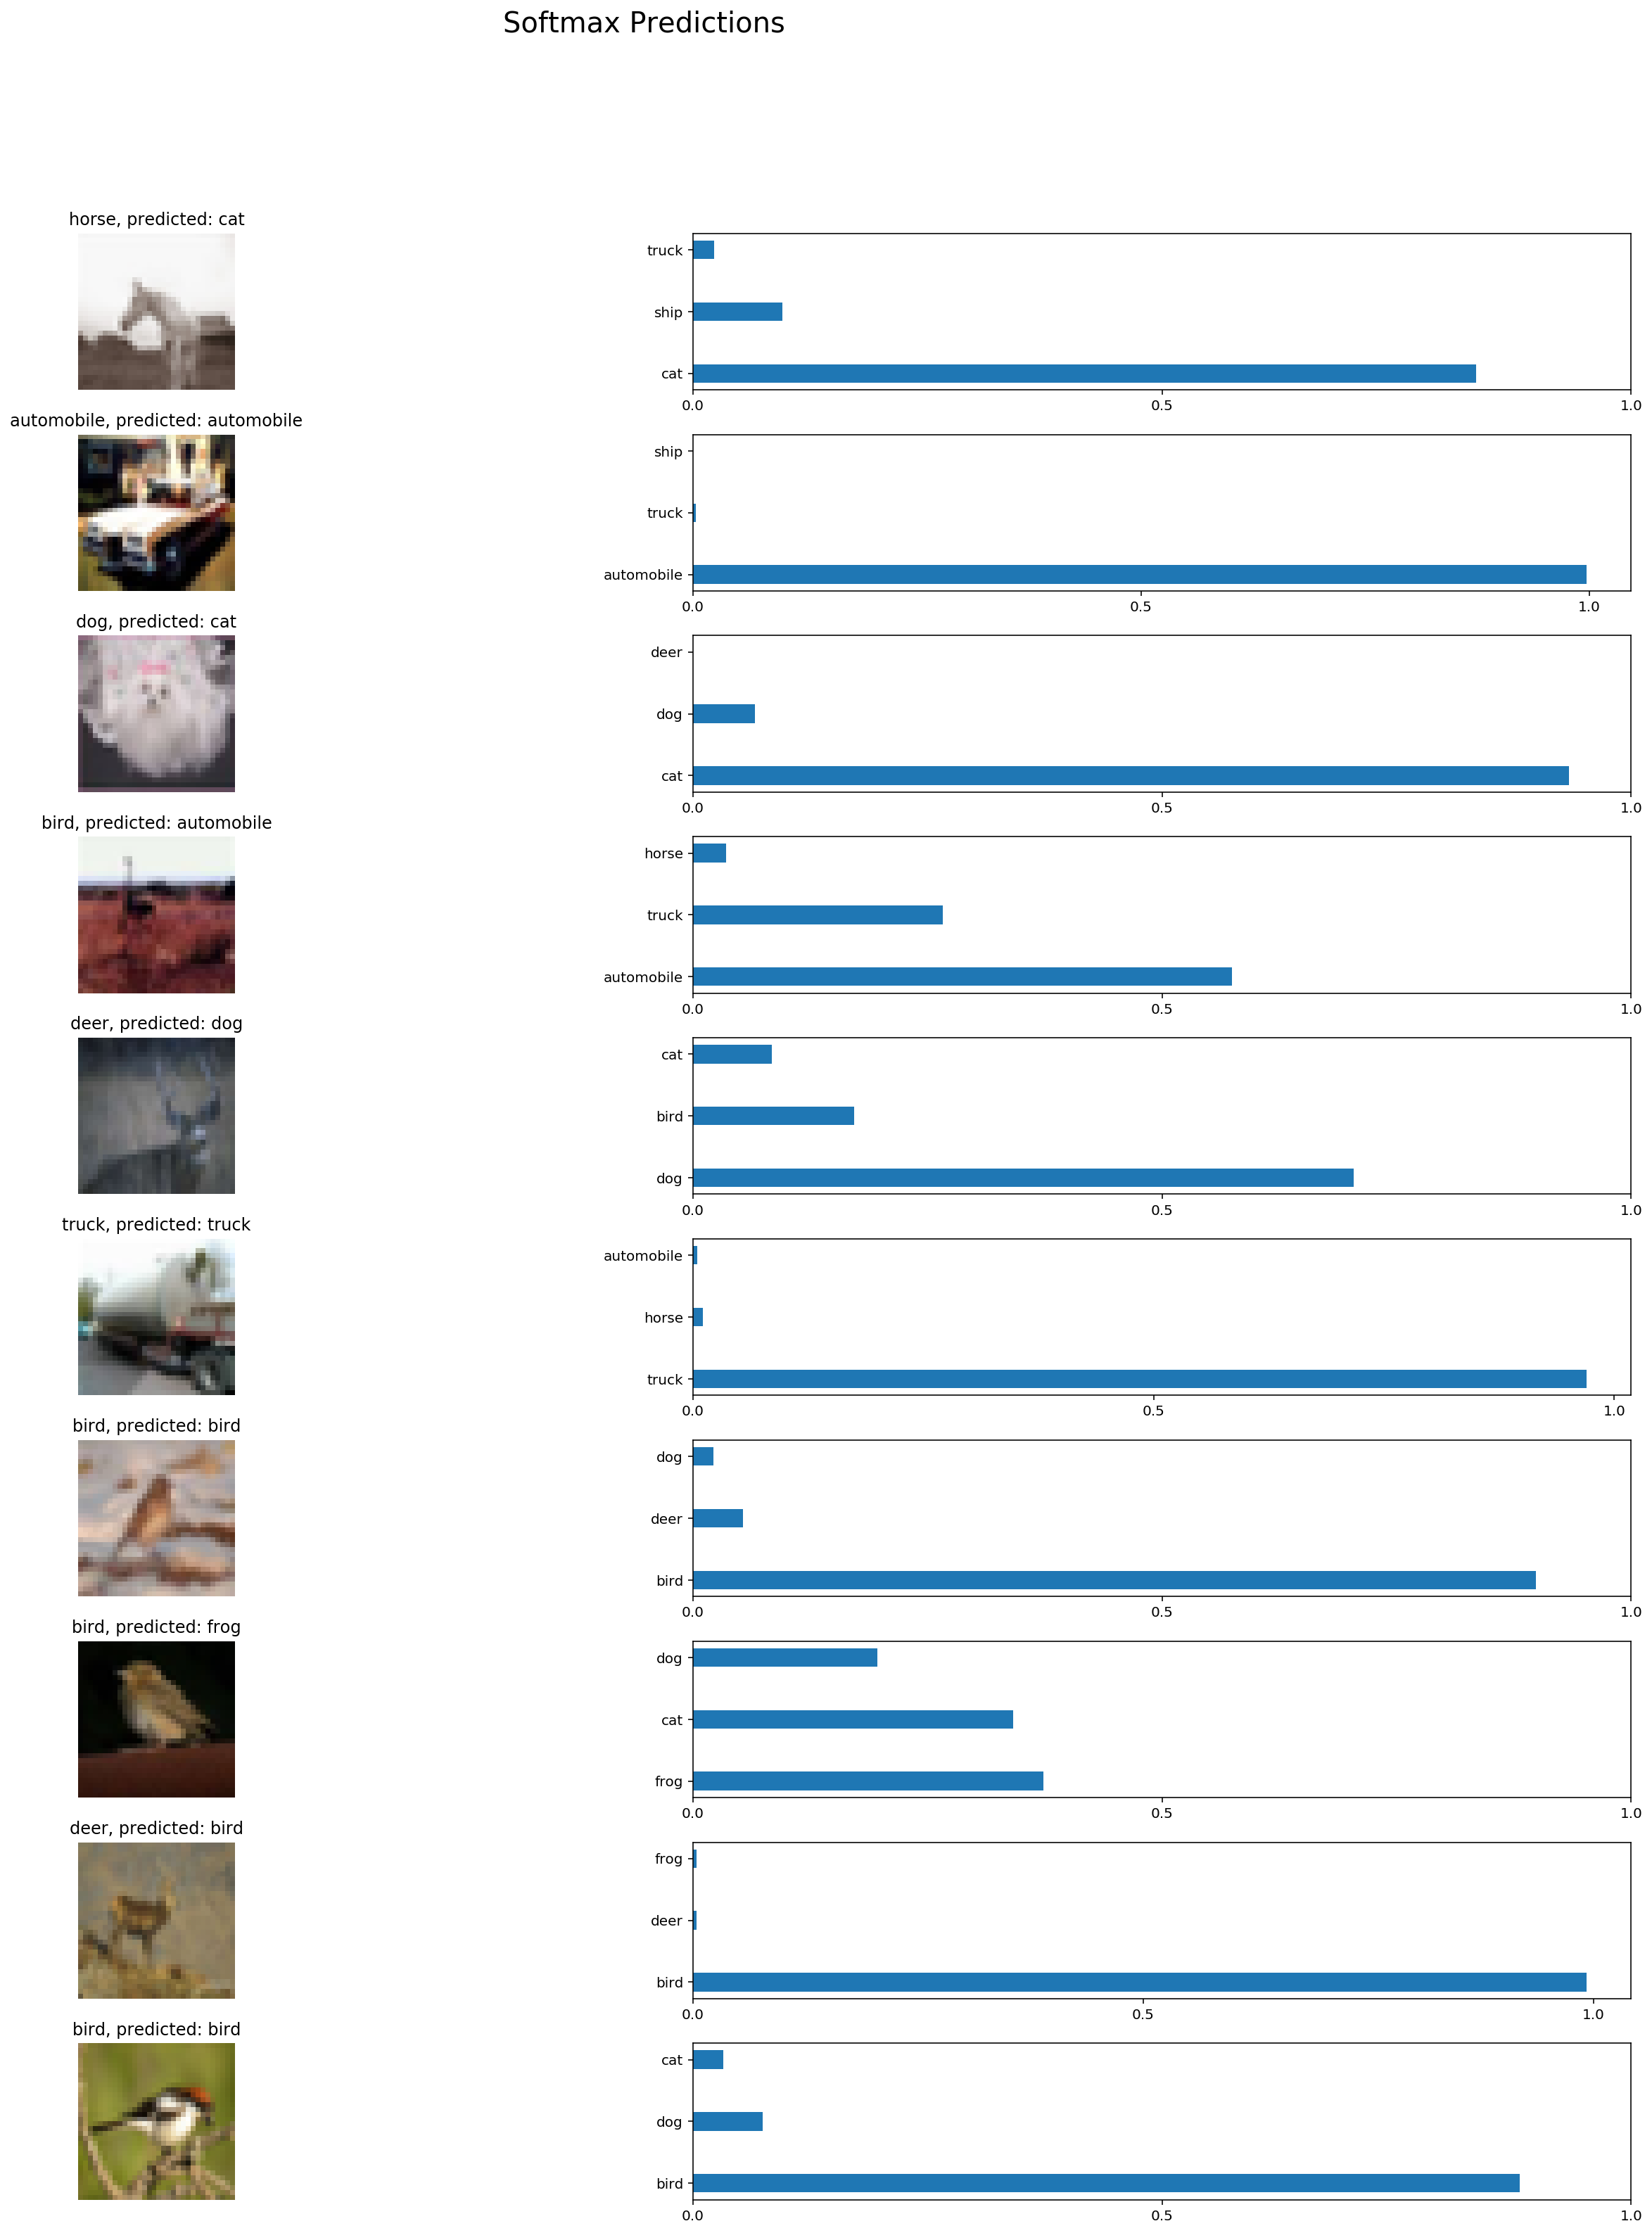

In [28]:

batch_size = 64
n_samples = 20
top_n_predictions = 10

save_model_path = './image_classification_imbalanced_augmented'
test_model(save_model_path,title='CNN on imbalanced CIFAR-10 (removed 90% airplanes) and kept airplains augmented 32 times')



## Let's try transferlearning with MobileNet50

Check tensornets:  https://github.com/taehoonlee/tensornets

In [72]:

!pip install tensornets
   

In [29]:
import tensornets as nets
import tensorflow as tf

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

# ImageNet input image shape is (244, 244, 3)
#inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])

# Output is dependent on your situation (10 for CIFAR-10)
#outputs = tf.placeholder(tf.float32, [None, 10])

# VGG19 returns the last layer (softmax)
# model to give the name
logits = nets.MobileNet50(x, is_training=True, classes=10)
model = tf.identity(logits, name='logits')

# loss function applied to the last layer
# train on the loss (Adam Optimizer is used)
loss = tf.losses.softmax_cross_entropy(y, logits)
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
train = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(loss)

# for measuring accuracy after forward passing
correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



### Lets run MobileNet50 on imbalanced data

In [31]:
save_model_path = './image_classification_MobileNet50-run4_batch64_imbalanced_only'

epochs = 3
batch_size = 64


print('Training...')
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    sess.run(logits.pretrained())
    print('model.pretrained ... done ... ')    
    
    # Training cycle
    print('starting training ... ')
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            i=0.0
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size,data_prefix='imbalanced_'):
                batch_features=convert_images(batch_features)
                sess.run(train, {x: batch_features, y: batch_labels})
                nr_minibatch = batch_features.shape[0]/batch_size
                i+=1
                percent=i/nr_minibatch
                #if(i%10==0):
                    #print(str(percent)+'% ', end='')
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            # calculate the mean accuracy over all validation dataset
            
            
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(valid_features, valid_labels, batch_size):
                batch_valid_features=convert_images(batch_valid_features)
                val_acc=sess.run(accuracy, {x:batch_valid_features, y:batch_valid_labels})
                #print(val_acc)
                valid_acc += val_acc
            
            tmp_num = valid_features.shape[0]/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
global_variables_initializer ... done ...
model.pretrained ... done ... 
starting training ... 
Epoch  1, CIFAR-10 Batch 1:  Validation Accuracy: 0.203400
Epoch  1, CIFAR-10 Batch 2:  Validation Accuracy: 0.351800
Epoch  1, CIFAR-10 Batch 3:  Validation Accuracy: 0.443400
Epoch  1, CIFAR-10 Batch 4:  Validation Accuracy: 0.546200
Epoch  1, CIFAR-10 Batch 5:  Validation Accuracy: 0.615400
Epoch  2, CIFAR-10 Batch 1:  Validation Accuracy: 0.651800
Epoch  2, CIFAR-10 Batch 2:  Validation Accuracy: 0.674200
Epoch  2, CIFAR-10 Batch 3:  Validation Accuracy: 0.689800
Epoch  2, CIFAR-10 Batch 4:  Validation Accuracy: 0.703000
Epoch  2, CIFAR-10 Batch 5:  Validation Accuracy: 0.709800
Epoch  3, CIFAR-10 Batch 1:  Validation Accuracy: 0.720600
Epoch  3, CIFAR-10 Batch 2:  Validation Accuracy: 0.725400
Epoch  3, CIFAR-10 Batch 3:  Validation Accuracy: 0.728600
Epoch  3, CIFAR-10 Batch 4:  Validation Accuracy: 0.734400
Epoch  3, CIFAR-10 Batch 5:  Validation Accuracy: 0.739400


In [41]:
save_model_path = './image_classification_MobileNet50-run4_batch64_imbalanced_only'
test_model(model_path=save_model_path,display=False,title='MobileNet50 on imbalanced CIFAR-10',convertImgTo224=True)


loading converted pictures of 224x224
Loading model: ./image_classification_MobileNet50-run4_batch64_imbalanced_only
INFO:tensorflow:Restoring parameters from ./image_classification_MobileNet50-run4_batch64_imbalanced_only
Testing Accuracy: 0.7310030396948469

Classification Report: MobileNet50 on imbalanced CIFAR-10

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00       299
  automobile       0.87      0.92      0.89       287
        bird       0.65      0.76      0.70       318
         cat       0.64      0.62      0.63       295
        deer       0.74      0.79      0.76       299
         dog       0.69      0.73      0.71       290
        frog       0.80      0.85      0.82       307
       horse       0.77      0.80      0.78       286
        ship       0.64      0.92      0.75       316
       truck       0.85      0.91      0.88       303

   micro avg       0.73      0.73      0.73      3000
   macro avg       0.66      0

### Run MobileNet50 with aumented data



In [27]:
save_model_path = './image_classification_MobileNet50-run3_batch64'

epochs = 5
batch_size = 64


print('Training...')
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    sess.run(logits.pretrained())
    print('model.pretrained ... done ... ')    
    
    # Training cycle
    print('starting training ... ')
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            i=0.0
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size,data_prefix='imbalanced_augmented_'):
                batch_features=convert_images(batch_features)
                sess.run(train, {x: batch_features, y: batch_labels})
                nr_minibatch = batch_features.shape[0]/batch_size
                i+=1
                percent=i/nr_minibatch
                #print(str(percent)+'% ', end='')
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            # calculate the mean accuracy over all validation dataset
            
            
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(valid_features, valid_labels, batch_size):
                batch_valid_features=convert_images(batch_valid_features)
                val_acc=sess.run(accuracy, {x:batch_valid_features, y:batch_valid_labels, keep_prob: 1.})
                #print(val_acc)
                valid_acc += val_acc
            
            tmp_num = valid_features.shape[0]/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    
    

Training...
global_variables_initializer ... done ...
model.pretrained ... done ... 
starting training ... 
Epoch  1, CIFAR-10 Batch 1:  Validation Accuracy: 0.261800
Epoch  1, CIFAR-10 Batch 2:  Validation Accuracy: 0.305800
Epoch  1, CIFAR-10 Batch 3:  Validation Accuracy: 0.343600
Epoch  1, CIFAR-10 Batch 4:  Validation Accuracy: 0.442200
Epoch  1, CIFAR-10 Batch 5:  Validation Accuracy: 0.524600
Epoch  2, CIFAR-10 Batch 1:  Validation Accuracy: 0.583000
Epoch  2, CIFAR-10 Batch 2:  Validation Accuracy: 0.647800
Epoch  2, CIFAR-10 Batch 3:  Validation Accuracy: 0.669000
Epoch  2, CIFAR-10 Batch 4:  Validation Accuracy: 0.680800
Epoch  2, CIFAR-10 Batch 5:  Validation Accuracy: 0.692000
Epoch  3, CIFAR-10 Batch 1:  Validation Accuracy: 0.699800
Epoch  3, CIFAR-10 Batch 2:  Validation Accuracy: 0.709200
Epoch  3, CIFAR-10 Batch 3:  Validation Accuracy: 0.714000
Epoch  3, CIFAR-10 Batch 4:  Validation Accuracy: 0.719400
Epoch  3, CIFAR-10 Batch 5:  Validation Accuracy: 0.727800


In [35]:
save_model_path = './image_classification_MobileNet50-run3_batch64'
test_model(model_path=save_model_path,display=False,title='MobileNet50 on imbalanced and augmented CIFAR-10',convertImgTo224=True)


(you can delete this, as the test were running on a different machine, so copied the results here)<br>

loading converted pictures of 224x224
Loading model: ./image_classification_MobileNet50-run4_batch64_imbalanced_only
INFO:tensorflow:Restoring parameters from ./image_classification_MobileNet50-run4_batch64_imbalanced_only
Testing Accuracy: 0.7703124992549419

Classification Report: MobileNet50 on imbalanced CIFAR-10

              precision    recall  f1-score   support

    airplane       0.43      0.92      0.58       103
    automobi       0.98      0.93      0.95        89
        bird       0.85      0.77      0.81       100
         cat       0.78      0.58      0.67       103
        deer       0.79      0.64      0.71        90
         dog       0.80      0.74      0.77        86
        frog       0.92      0.76      0.83       112
       horse       0.91      0.78      0.84       102
        ship       0.94      0.80      0.87       106
       truck       0.96      0.89      0.92       109
       
       micro avg       0.78      0.78      0.78      1000
       macro avg       0.84      0.78      0.80      1000
    weighted avg       0.84      0.78      0.80      1000

### Checking: is it just the architecture better at MobileNet50?

In [28]:

save_model_path = './image_classification_MobileNet50-run3_batch64_without_pretrained'

epochs = 3
batch_size = 64


print('Training...')
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    #sess.run(logits.pretrained())
    print('model.pretrained ... done ... ')    
    
    # Training cycle
    print('starting training ... ')
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            i=0.0
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size,data_prefix='imbalanced_augmented_'):
                batch_features=convert_images(batch_features)
                sess.run(train, {x: batch_features, y: batch_labels})
                nr_minibatch = batch_features.shape[0]/batch_size
                i+=1
                percent=i/nr_minibatch
                #print(str(percent)+'% ', end='')
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            # calculate the mean accuracy over all validation dataset
            
            
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(valid_features, valid_labels, batch_size):
                batch_valid_features=convert_images(batch_valid_features)
                val_acc=sess.run(accuracy, {x:batch_valid_features, y:batch_valid_labels, keep_prob: 1.})
                #print(val_acc)
                valid_acc += val_acc
            
            tmp_num = valid_features.shape[0]/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    
    


Training...
global_variables_initializer ... done ...
model.pretrained ... done ... 
starting training ... 
Epoch  1, CIFAR-10 Batch 1:  Validation Accuracy: 0.115000
Epoch  1, CIFAR-10 Batch 2:  Validation Accuracy: 0.135800
Epoch  1, CIFAR-10 Batch 3:  Validation Accuracy: 0.137200
Epoch  1, CIFAR-10 Batch 4:  Validation Accuracy: 0.137800
Epoch  1, CIFAR-10 Batch 5:  Validation Accuracy: 0.143600
Epoch  2, CIFAR-10 Batch 1:  Validation Accuracy: 0.145200
Epoch  2, CIFAR-10 Batch 2:  Validation Accuracy: 0.149400
Epoch  2, CIFAR-10 Batch 3:  Validation Accuracy: 0.149200
Epoch  2, CIFAR-10 Batch 4:  Validation Accuracy: 0.154400
Epoch  2, CIFAR-10 Batch 5:  Validation Accuracy: 0.152600
Epoch  3, CIFAR-10 Batch 1:  Validation Accuracy: 0.167800
Epoch  3, CIFAR-10 Batch 2:  Validation Accuracy: 0.176400
Epoch  3, CIFAR-10 Batch 3:  Validation Accuracy: 0.175400
Epoch  3, CIFAR-10 Batch 4:  Validation Accuracy: 0.178200
Epoch  3, CIFAR-10 Batch 5:  Validation Accuracy: 0.177200


In [36]:
# no need for testing.
#save_model_path = './image_classification_MobileNet50-run3_batch64_without_pretrained'
#test_model(model_path=save_model_path,display=False,title='MobileNet50 on imbalanced and augmented CIFAR-10 without pretrained',convertImgTo224=True)


# Summary

<table>
    <tr><th>Model Name and Dataset</th><th>Test Accuracy</th><th>Precision</th><th>Recall</th><th>F-score</th><th>Minority class Precision</th><th>Minority class Recall</th><th>Minority class F-score</th></tr>
    <tr><td>Baseline CNN CIFAR-10 (10 epoch)</td><td>71.5%</td><td>.74</td><td>.72</td><td>.72</td><td>.89</td><td>.63</td><td>.74</td></tr>
    <tr><td>Same CNN with imbalanced CIFAR-10</td><td>65.8%</td><td>.71</td><td>.66</td><td>.65</td><td>.94</td><td>.16</td><td>.28</td></tr>
    <tr><td>Same CNN with imb. CIFAR-10 and Augmented</td><td>69.6%</td><td>.72</td><td>.70</td><td>.69</td><td>.86</td><td>.38</td><td>.53</td></tr>
    <tr><td><b>Transfer Learning with MobileNet50</b> </td></tr>
    <tr><td>MobileNet50 with imb. CIFAR-10 (3 epoch)</td><td>73.1%</td><td>.66</td><td>.73</td><td>.69</td><td>.00</td><td>.00</td><td>.00</td></tr>
    <tr><td>MobileNet50 with imb. CIFAR-10 (5 epoch)</td><td>76.9%</td><td>.70</td><td>.78</td><td>.73</td><td>.00</td><td>.00</td><td>.00</td></tr>
    <tr><td>MobileNet50 with imb. CIFAR-10 and Augmented</td><td>77.0%</td><td>.84</td><td>.78</td><td>.80</td><td>.43</td><td>.92</td><td>.58</td></tr>
    <tr><td>MobileNet50 on CIFAR-10 without Transferlearning</td><td>17.7%</td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
        
</table>